# Pytorch Computer Vision

## 0. Computer vision libraries in PyTorch

* `torchvision` - base domain library for PyTorch computer vision

* `torchvision.datasets` - get datasets and data loading functions for computer vision here

* `torchvision.models` - get pretrained computer vision models that you can leverage for your own problems

* `torchvision.transforms` - functions for manipulating your vision data (images) to be suitable for use with an ML model

* `torch.utils.data.Dataset` - Base dataset class for PyTorch

* `torch.utils.data.DataLoader` - Creates a Python iterable over a dataset

In [66]:
import torch
from torch import nn

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt

## 1. Getting a dataset

The dataset we'll be using is FashionMNIST from torchvision.datasets

In [67]:
# Setup training data
train_data = datasets.FashionMNIST(
    root='data',
    train=True,
    transform=torchvision.transforms.ToTensor(),
    target_transform=None,
    download=True,
)

test_data = datasets.FashionMNIST(
    root='data',
    train=False,
    transform=torchvision.transforms.ToTensor(),
    target_transform=None,
    download=True,
)

In [68]:
len(train_data), len(test_data)

(60000, 10000)

In [69]:
# See the first training example
image, label = train_data[0]
image[0, 5], label

(tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0235, 0.0000, 0.4000, 0.8000, 0.6902, 0.5255,
         0.5647, 0.4824, 0.0902, 0.0000, 0.0000, 0.0000, 0.0000, 0.0471, 0.0392,
         0.0000]),
 9)

In [70]:
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [71]:
class_to_idx = train_data.class_to_idx
class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

### 1.1 Check input and output shapes of data

In [72]:
# Check the shape of our image
print(f"Image shape: {image.shape} -> [color_channels, height, width]")
print(f"Image label: {class_names[label]}")

Image shape: torch.Size([1, 28, 28]) -> [color_channels, height, width]
Image label: Ankle boot


### 1.2 Visualizing our data

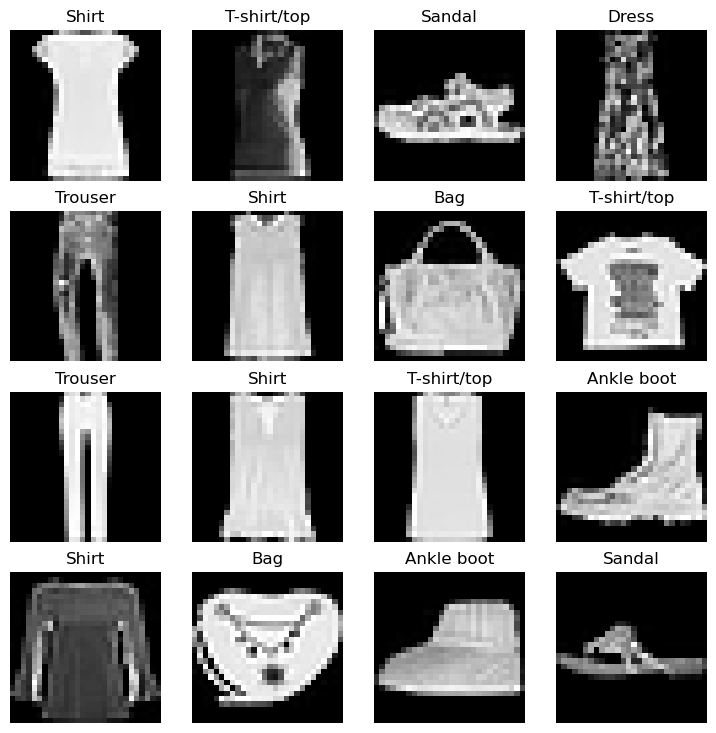

In [73]:
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows*cols+1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(class_names[label])
    plt.axis(False)

## 2. Prepare DataLoader

Right now, our data is in the form of PyTorch Datasets.

Recall: DataLoader turns our dataset into a Python iterable.

More specifically, we want to turn our data into batches (or mini-batches).

Why would we do this?

1. It is more computationally efficient, as in, your computing hardware may not be able to look (store memory) at 60000 images in one hit. So we break it down to 32 images at a time (batch size of 32).
2. It gives our neural network more chances to update its gradients per epoch. Instead of updating our gradients every 60000 images (so once per epoch), the optimizer updates the gradients every 32 images (no matter the epoch).

In [74]:
from torch.utils.data import DataLoader

# Setup the batch size hyperparameter
BATCH_SIZE = 32

# Turn datasets into iterables (batches)
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=False)

# Let's check out what we have created
print(f"DataLoaders: {train_dataloader, test_dataloader}")
print(f"Length of the train_dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}...")
print(f"Length of test_dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}...")

DataLoaders: (<torch.utils.data.dataloader.DataLoader object at 0x7caa9475a420>, <torch.utils.data.dataloader.DataLoader object at 0x7caa947599a0>)
Length of the train_dataloader: 1875 batches of 32...
Length of test_dataloader: 313 batches of 32...


In [75]:
# Check out what's inside the training dataloader
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

Image size: torch.Size([1, 28, 28])
Label: 2, label size: torch.Size([])


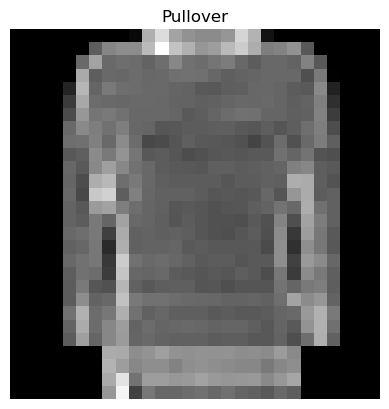

In [76]:
# Show a sample
random_idx = torch.randint(0, len(train_features_batch), size=[1]).item()
img, label = train_features_batch[random_idx], train_labels_batch[random_idx]
plt.imshow(img.squeeze(), cmap="gray")
plt.title(class_names[label])
plt.axis(False)
print(f"Image size: {img.shape}")
print(f"Label: {label}, label size: {label.shape}")

## 3. Model 0: Build a baseline model

When starting to build a series of machine learning modelling experiments, it's best practice to start with a baseline model. A baseline model is a simple model you will try and improve upon with subsequent models/experiments.

In other words: start simply and add complexity when necessary.

In [77]:
# Create a flatten layer
flatten_model = nn.Flatten()

# Get a single sample
x = train_features_batch[0]

# Flatten the sample
output = flatten_model(x)   # perform forward pass

# Print out what happened
print(f"Shape before flattening: {x.shape} -> [color_channels, height, width]")
print(f"Shape after flattening: {output.shape} -> [color_channels, height * width]")

Shape before flattening: torch.Size([1, 28, 28]) -> [color_channels, height, width]
Shape after flattening: torch.Size([1, 784]) -> [color_channels, height * width]


In [78]:
class FashionMNISTModelV0(nn.Module):
    def __init__(self,
                input_shape: int,
                hidden_units: int,
                output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape, 
                    out_features=hidden_units),
            nn.Linear(in_features=hidden_units, 
                    out_features=output_shape),
        )

    def forward(self, x):
        return self.layer_stack(x)

In [79]:
# Setup model with input parameters
model_0 = FashionMNISTModelV0(
    input_shape=28*28,
    hidden_units=10,
    output_shape=len(class_names)
).to('cpu')

model_0

FashionMNISTModelV0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [80]:
dummy_x = torch.rand([1, 1, 28, 28])
model_0(dummy_x)

tensor([[ 0.0287, -0.0609, -0.1067,  0.2593,  0.0311, -0.2014,  0.2295, -0.3113,
         -0.1560, -0.1855]], grad_fn=<AddmmBackward0>)

In [81]:
model_0.state_dict()

OrderedDict([('layer_stack.1.weight',
              tensor([[ 0.0252, -0.0020, -0.0247,  ..., -0.0020, -0.0163,  0.0057],
                      [-0.0007, -0.0167,  0.0311,  ..., -0.0208,  0.0236,  0.0156],
                      [-0.0116, -0.0320,  0.0277,  ..., -0.0344,  0.0172,  0.0064],
                      ...,
                      [ 0.0186,  0.0303,  0.0338,  ...,  0.0077, -0.0263,  0.0310],
                      [ 0.0275,  0.0155,  0.0172,  ..., -0.0080, -0.0152, -0.0124],
                      [ 0.0154,  0.0223, -0.0137,  ..., -0.0223, -0.0193,  0.0190]])),
             ('layer_stack.1.bias',
              tensor([-0.0331, -0.0234,  0.0088,  0.0284, -0.0237, -0.0185, -0.0247,  0.0282,
                       0.0288, -0.0005])),
             ('layer_stack.2.weight',
              tensor([[-0.1049, -0.1786, -0.1374, -0.0102,  0.0961,  0.2483,  0.0073, -0.2536,
                        0.3159,  0.2448],
                      [ 0.1262, -0.0356,  0.1685, -0.1834,  0.2865, -0.0597, -0.

### 3.1 Setup loss, optimizer and evaluation metrics

* Loss function - since we're working with multi-class data, our loss function will be `nn.CrossEntropyLoss()`

* Optimizer - our optimizer `torch.optim.SGD()` (stochastic gradient descent)

* Evaluation metric - since we are working on a classification problem, let's use accuracy as

In [82]:
from helper_functions import accuracy_fn

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_0.parameters(),
                            lr=0.1)

### 3.2 Creating a function to time our experiments

Machine learning is very experimental.

Two of the main things you'll often want to track are:
1. Model's performance (loss, accuracy, etc)
2. How fast it runs

In [83]:
from timeit import default_timer as timer

def print_train_time(start: float,
                     end: float,
                     device: torch.device = None):
    """Prints difference between start and end time."""
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

### 3.3 Creating a training loop and training a mode on batches of data

1. Loop through epochs.
2. Loop through training batches, perform training steps, calculate the train loss *per batch*.
3. Loop through testing batches, perform testing steps, calculate the test loss *per batch*.
4. Print out what's happening.
5. Time it all (for fun).

In [84]:
from tqdm.auto import tqdm

# Start the timer to measure training duration
train_time_start_on_cpu = timer()

# Set the number of epochs (we'll keep this small for faster training time)
epochs = 3

# Create training and test loop
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n--------")
    
    ### Training
    train_loss = 0

    # Add a loop to loop through the training batches
    for batch, (X, y) in enumerate(train_dataloader):
        model_0.train()
        
        # 1. Forward pass
        y_pred = model_0(X)

        # 2. Calculate the loss (per batch)
        loss = loss_fn(y_pred, y)
        train_loss += loss

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Print out what's happening
        if batch % 400 == 0:
            print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples.")

    # Divide total train loss by length of train dataloader
    train_loss /= len(train_dataloader)

    ### Testing
    test_loss, test_acc = 0, 0
    model_0.eval()
    with torch.inference_mode():
        for X_test, y_test in test_dataloader:
            # 1. Forward pass
            test_pred = model_0(X_test)

            # 2. Calculate loss (accumulatively)
            test_loss += loss_fn(test_pred, y_test)

            # 3. Calculate accuracy
            test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred.argmax(dim=1))

        # Calculate the test loss average per batch
        test_loss /= len(test_dataloader)

        # Calculate the test acc average per batch
        test_acc /= len(test_dataloader)

    # Print out what's happening
    print(f"\n Train loss: {train_loss:.4f} | Test loss: {test_loss:.4f}, Test acc: {test_acc:.4f}\n")

# Calculate the training time
train_time_end_on_cpu = timer()
total_train_time_model_0_cpu = print_train_time(start=train_time_start_on_cpu, end=train_time_end_on_cpu, device=str(next(model_0.parameters()).device))

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
--------
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.

 Train loss: 0.5905 | Test loss: 0.4856, Test acc: 0.2796

Epoch: 1
--------
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.

 Train loss: 0.4747 | Test loss: 0.4876, Test acc: 0.2995

Epoch: 2
--------
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.

 Train loss: 0.4556 | Test loss: 0.4899, Test acc: 0.2995

Train time on cpu: 14.381 seconds


## 4. Make predictions and get Model 0 results

In [90]:
for i, (X, y) in enumerate(test_data):
    print(torch.tensor(y))

    if i == 4:
        break

tensor(9)
tensor(2)
tensor(1)
tensor(1)
tensor(6)


In [92]:
def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.dataloader,
               loss_fn: torch.nn.Module,
               accuracy_fn):
    """Returns a dictionary containing the results of model predicting on data_loader."""
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in tqdm(data_loader):
            # Make predictions
            y_pred = model(X)

            # Accumulate the loss and acc values per batch
            loss +=loss_fn(y_pred, y)
            acc += accuracy_fn(y_true=y,
                               y_pred=y_pred.argmax(dim=1))
            
        # Scale loss and acc to find the average loss/acc per batch
        loss /= len(data_loader)
        acc /= len(data_loader)

    return {"model_name": model.__class__.__name__, # this only works when the model was created with a class
            "model_loss": loss.item(),
            "model_acc": acc}

# Calculate model 0 results on test dataset
model_0_results = eval_model(model=model_0,
                             data_loader=test_dataloader,
                             loss_fn=loss_fn,
                             accuracy_fn=accuracy_fn)

model_0_results

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'FashionMNISTModelV0',
 'model_loss': 0.4898809492588043,
 'model_acc': 82.74760383386581}

## 5. Setup device agnostic-code (for using a GPU if there is one)